In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from pyopls import OPLS
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.metrics import accuracy_score, f1_score, recall_score,confusion_matrix,roc_curve,roc_auc_score, RocCurveDisplay, classification_report

# Exploratory Data Analysis: 
1. Checking for missing values.
2. Generating correlation matrix and basic understanding of the dataset before building the model.

In [155]:
data = pd.read_csv(r'C:\Users\supra\winequality(white)\winequality-white.csv', delimiter=';')
print(data.isna().sum())
data.head()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


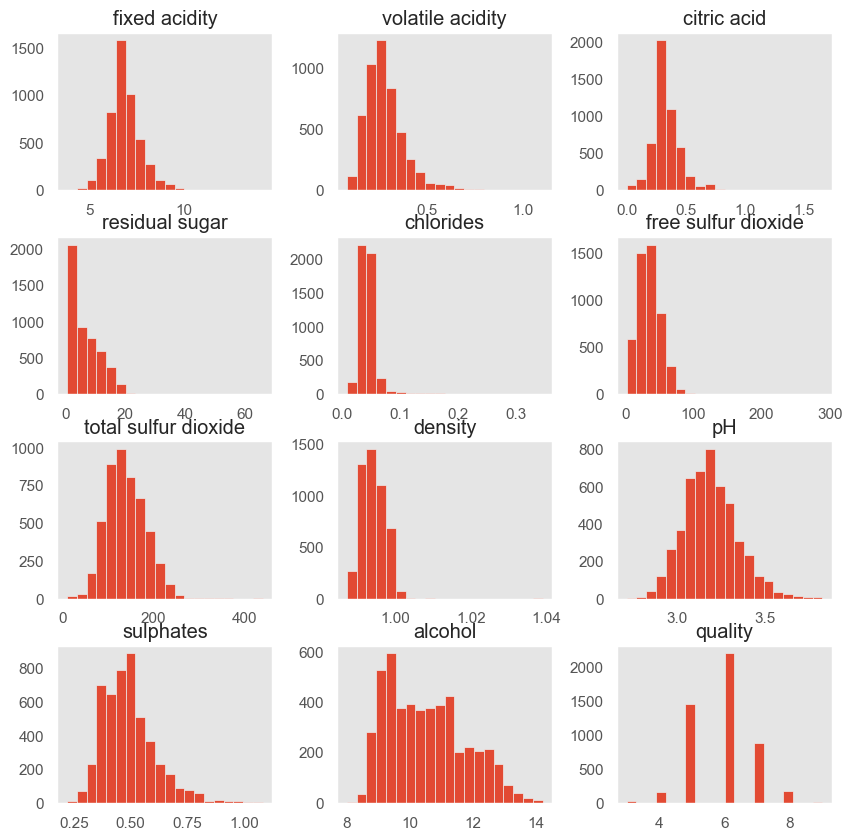

In [156]:
style.use('ggplot')
data.hist(bins =20, figsize=(10,10), grid=False)
plt.show()

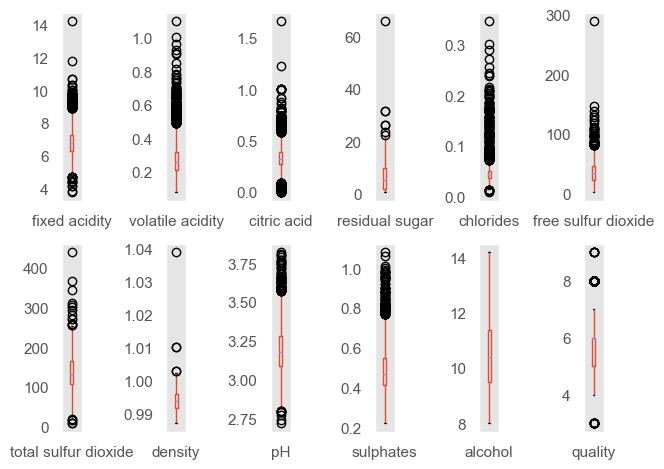

In [157]:
style.use('ggplot')
fig, axes = plt.subplots(2,6) # create figure and axes
for i,el in enumerate(list(data.columns.values)):
    a = data.boxplot(el, ax=axes.flatten()[i], grid=False)
plt.tight_layout() 
plt.show()

In [ ]:
sns.pairplot(data, hue='quality')

In [ ]:
corr_matrix = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, cbar=True)

From the correlation matrix, the following conclusions can be made,
1. Residual suagr is highly correlated to density with coefficient value of 0.84
2. Total sulfur dioxide is moderately correlated to free sulfur dioxide with coefficient value of 0.62

In [ ]:
X = data.drop('quality', axis='columns')
y = data['quality']
y_unique = y.unique()
print(y_unique)

In [ ]:
y_clf = y.apply(lambda x: 0 if x<7 else 1)
print(y_clf.value_counts())

Dividing the dependent variable to 2 classes
Batches having quality score greater than 6 are considered to be a high quality wine and the other batches as poor quality wine.

# Building the model

In [ ]:
scaling = StandardScaler()
X_scaled = scaling.fit_transform(X)

RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_clf, test_size=0.2, random_state=RANDOM_SEED)

model = [ LogisticRegression, RandomForestClassifier, DecisionTreeClassifier]

for i in range(len(model)):
    clf = model[i]()
    clf.fit(X_train, y_train)
    print('Score of:', model[i], 'is', clf.score(X_test, y_test))
    
model1 = RandomForestClassifier()
model1.fit(X_train, y_train)
print('\n Score:', model1.score(X_test, y_test))
y_pred = model1.predict(X_test)

In [ ]:
feature_significane = model1.feature_importances_
feature = X.columns
plt.figure(figsize=(18,5))
plt.bar(feature, feature_significane, width=0.5) 
plt.tight_layout()  
plt.show() 

In [ ]:
df1 = pd.concat([X, y_clf], axis=1)
df1.head()


In [ ]:
fig, axes = plt.subplots(5,2, figsize=(15, 20), sharey=True)
k=0
for i in range(2):
    for j in range(5):
        sns.scatterplot(ax=axes[j,i], x = df1.iloc[:,k], y =df1.iloc[:,10], hue=y_clf)
        axes[j,i].legend(bbox_to_anchor=(1.15,1))
        k=k+1

From the following graphs, it can be concluded that higher alcohol content, lower chloride content and lower density value will result in a good quality wine.

# Evaluation matrix

In [ ]:
A = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,3))
sns.heatmap(A, annot=True, cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True') 
   
report = classification_report(y_test, y_pred)
print('\n Classification report:\n', report)
RocCurveDisplay.from_predictions(y_test, y_pred)   

Classification report:
The dataset here is imbalanced since the value count(753) for class 0 is relatively high when compared to the value count(227) of class 1.

Precision : Proportion of positive predictions which are actually correct. The ideal value for it is 1. The current model has a precision value of 0.91 and 0.87 for '0' and '1' class respectively.

Recall : Calculates the proportion of true positive prediction. The ideal value for it is 1. The current model has a recall values of 0.97 amd 0.67 for '0' and '1' class respectively.

F1 score : combination of both precison and recall. The ideal value is 1. The current model has a recall values of 0.94 amd 0.75 for '0' and '1' class respectively.

Confusion matrix summarizes the performance of a classification model.
True Negative : 730
True Positive : 150
False Positive : 23
False Negative : 76

ROC curve : Plot of True positive rate vs the False positive rate. The area under the ROC curve gives information about the performance of a classification model. The ideal value is 1. The current model has an AUC score of 0.82.

# OPLS Discriminant Analysis: 

In [ ]:
def opls_func(n_components, X,y):
    opls = OPLS(n_components=1)
    Z =opls.fit_transform(X,y)
    pls = PLSRegression(1)
    pls.fit(Z,y)
    df = pd.DataFrame(np.column_stack([pls.x_scores_, opls.T_ortho_[:,0]]),
                      index=X.index,columns = ['x_score','t_ortho'])
    a = df[y==3]
    b = df[y==4]
    c = df[y==5]
    d = df[y==6]
    e = df[y==7]
    f = df[y==8]
    g = df[y==9]
    
    plt.scatter(a['x_score'], a['t_ortho'], c='red', label=3)
    plt.scatter(b['x_score'], b['t_ortho'], c='orange', label=4)
    plt.scatter(c['x_score'], c['t_ortho'], c='yellow', label=5)
    plt.scatter(d['x_score'], d['t_ortho'], c='blue', label=6)
    plt.scatter(e['x_score'], e['t_ortho'], c='lightgreen', label=7)
    plt.scatter(f['x_score'], f['t_ortho'], c='green', label=8)
    plt.scatter(g['x_score'], g['t_ortho'], c='black', label=9)
    
    plt.axhline(y=-2, color='black', linestyle ='--')
    plt.axvline(x=0, color='black', linestyle ='--')
    plt.title('OPLS DA Analysis')
    plt.xlabel('x_score')
    plt.ylabel('t_ortho')
    plt.xlim(-10,20)
    plt.legend( bbox_to_anchor=(1,1), loc='center left')
    plt.show()
       
opls_func(1, X, y)

From the above graph, clustering can be observed between the high quality and low quality wine batches. It can be observed that the batches with the wine quality score 7,8,9 are largely clustered in the upper right quadrant.